# The Quarterly Japanese Economic Model (Q-JEM)
This workbook implement the "The Quarterly Japanese Economic Model (Q-JEM): 2019 version". 

At http://www.boj.or.jp/en/research/wps_rev/wps_2019/wp19e07.htm/ you will find the working paper describing 
the model and a zipfile containing all the relevant information needed to use the model. 

The model logic has been transformed from Eview equation to ModelFlow Business logic and the dataseries has been transformed to a Pandas Dataframe. 

In this workbook the impulse responses from the working paper section 3.1.1, 3.1.2, 3.1.3, and 3.1.4 has been recreated. 

In [1]:
import pandas as pd 

import sys
sys.path.append('modelflow/')

from modelsandbox import newmodel
import modelnet as mn

ModelFlow info: CVXopt not installed. Only matters if you are incorporating optimization


# Create model and dataframe 

In [2]:
with open('qjem/model/fqjem.frm','rt') as f: 
    fqjem =f.read()
baseline = pd.read_pickle('qjem/data/dfqjem.pk')    

mqjem = newmodel(fqjem)

mqjem.use_preorder = 1 # make a block decomposition of the model 
turbo = 0              # 1 sppeds up by compiling with Numba, 0 use straight python 

This model has simultaneous elements or cyclical elements. The formulars will be evaluated in input sequence


# Define some variable labels 

In [3]:
legend = {
'GDP'   : 'Real gross domestic product, S.A.',
'CP'    : 'Real private consumption, S.A.',
'U'     : 'Unemployment rate, S.A.',
'PGDP'  : 'GDP deflator',
'USGDP' : 'Real gross domestic product of the United States, S.A.',
'NUSGDP': 'Output gap of the rest of the world',
'EX': 'Real exports of goods and services, S.A.',
'IM' : 'Real imports of goods and services, S.A.',
'INV' : 'Real private non-residential investment, S.A.',
'CORE_CPI' : 'Consumer price index (all items, less fresh food), S.A.'
}

# Run the baseline 

In [4]:
res = mqjem(baseline,antal=50,first_test = 1,ljit=turbo,chunk=49,silent=1)

# Make experiment with Foreign GDP +1 percent point. 

In [5]:
instruments = [ 'V_NUSGAP','V_USGAP']
target      = baseline.loc['2005q1':,['USGDP','NUSGDP']].mfcalc('''\
USGDP  = USGDP*1.01
NUSGDP = NUSGDP*1.01
''',silent=1)
resalt = mqjem.control(baseline,target,instruments,silent=1)

# Display the results 

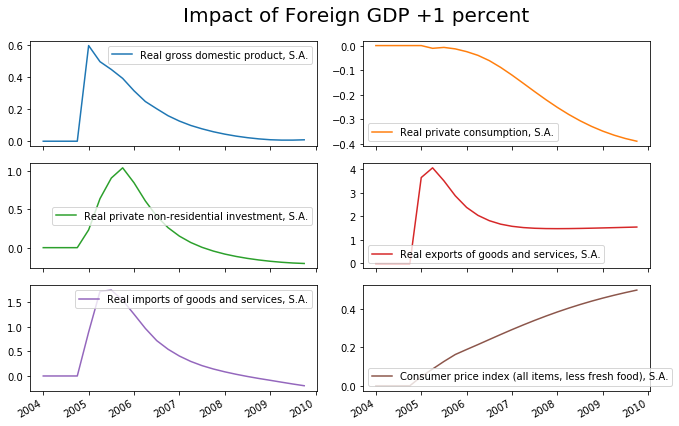

In [6]:
disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.mul100.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of Foreign GDP +1 percent',top=0.9)

# The experiment with Oil prices and show the results 

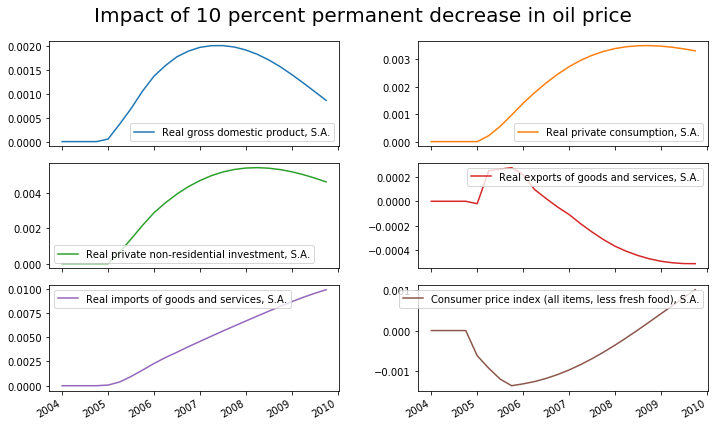

In [7]:
instruments = [ 'V_POIL']
target      = baseline.loc['2005q1':,['POIL']].mfcalc('''\
POIL  = POIL*0.9
''',silent=1)

resalt = mqjem.control(baseline,target,instruments,silent=1)

disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of 10 percent permanent decrease in oil price',top=0.9)

# Combine the two previous experiments 

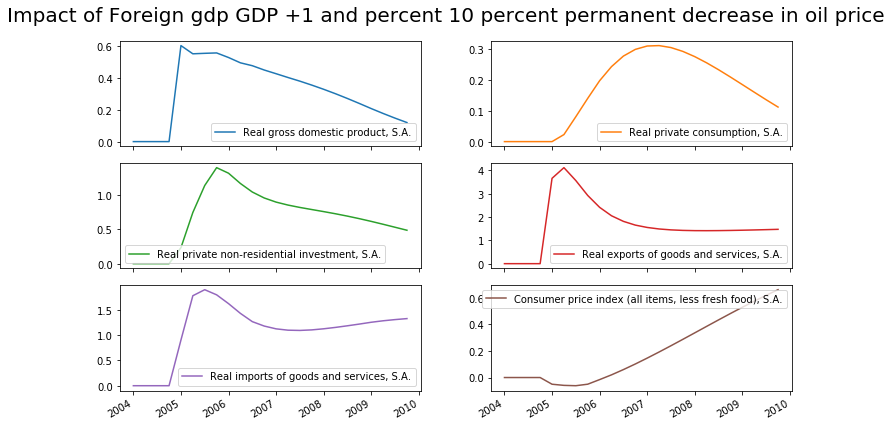

In [8]:
instruments = [ 'V_POIL','V_NUSGAP','V_USGAP']
target      = baseline.loc['2005q1':,['POIL','USGDP','NUSGDP']].mfcalc('''\
POIL  = POIL*0.9
USGDP  = USGDP*1.01
NUSGDP = NUSGDP*1.01
''',silent=1)

resalt = mqjem.control(baseline,target,instruments,silent=1)

disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.mul100.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of Foreign gdp GDP +1 and percent 10 percent permanent decrease in oil price',top=0.9)

# A permanent depreciation of exchange rates. 

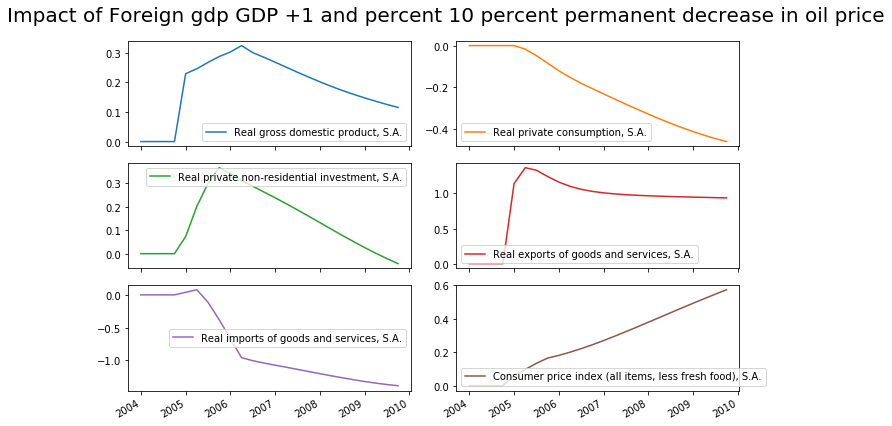

In [9]:
instruments = [ 'V_FXYEN']
target      = baseline.loc['2005q1':,['FXYEN']].mfcalc('''\
FXYEN = FXYEN*1.1
''',silent=1)

resalt = mqjem.control(baseline,target,instruments,silent=1)

disp = mqjem['GDP CP INV EX IM CORE_CPI'].difpctlevel.mul100.rename(legend).plot(
    colrow=2,sharey=0,title='Impact of Foreign gdp GDP +1 and percent 10 percent permanent decrease in oil price',top=0.9)

# Draw the causal structure 

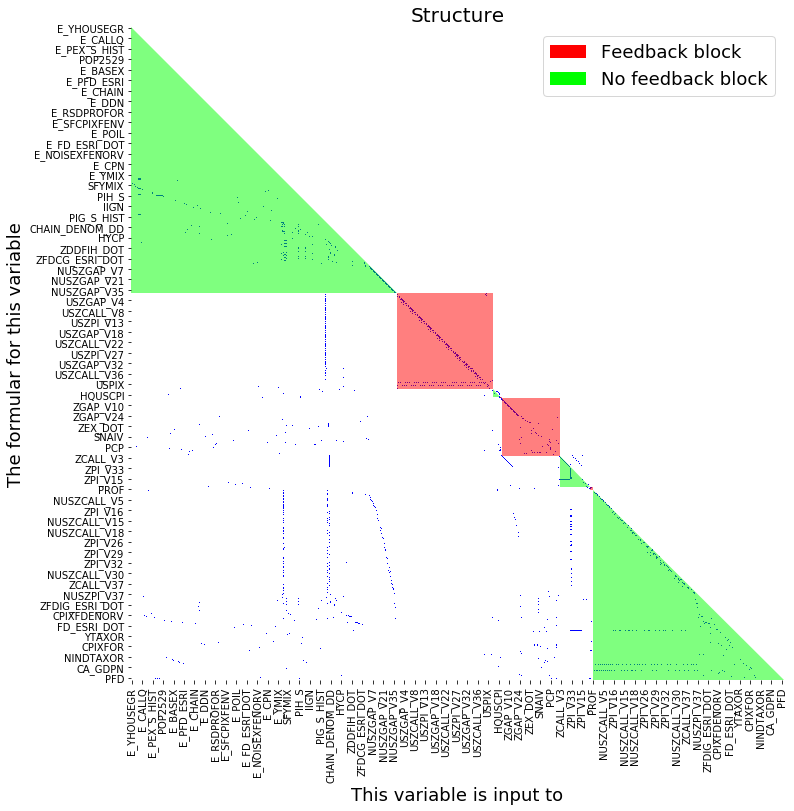

In [10]:
    fig2 = mn.draw_adjacency_matrix(mqjem.endograph,mqjem.precoreepiorder,mqjem._superstrongblock,mqjem._superstrongtype,
                                    size=(12,12))